<a href="https://colab.research.google.com/github/crisdavid3335/analytics_with_KERAS/blob/main/SpaceshipTitanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Importamos las librerías necesarias
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno

import os 
import warnings 

warnings.filterwarnings('ignore')


from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score

import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance

import keras
from keras import layers
from keras.utils.vis_utils import plot_model

In [ ]:
# Cargamos los datos
sub = pd.read_csv('/content/drive/MyDrive/Proyectos/Spaceship Titanic/sample_submission.csv')
test = pd.read_csv('/content/drive/MyDrive/Proyectos/Spaceship Titanic/test.csv')
train = pd.read_csv('/content/drive/MyDrive/Proyectos/Spaceship Titanic/train.csv')

# Visualizamos los datos existentes
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [ ]:
# Los datos se componen de dos tipos, objetos, decimales y el objetivo de tipo booleano
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [ ]:
# Valores nulos
print('='*65)
print('='*15 +'Valores nulos de entrenamiento'+'='*15)
print('='*65)
print(train.isnull().sum())
print('='*65)
print('='*15 +'Valores nulos de prueba'+'='*15)
print('='*65)
print(test.isnull().sum())

===============Valores nulos de entrenamiento===============
PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64
===============Valores nulos de prueba===============
PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64


In [ ]:
# Se separan los datos categóricos de los valores numéricos
cat_cols = ['HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'VIP', 'Name']

num_cols = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

target = 'Transported'

id = 'PassengerId'

In [ ]:
train.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported'],
      dtype='object')

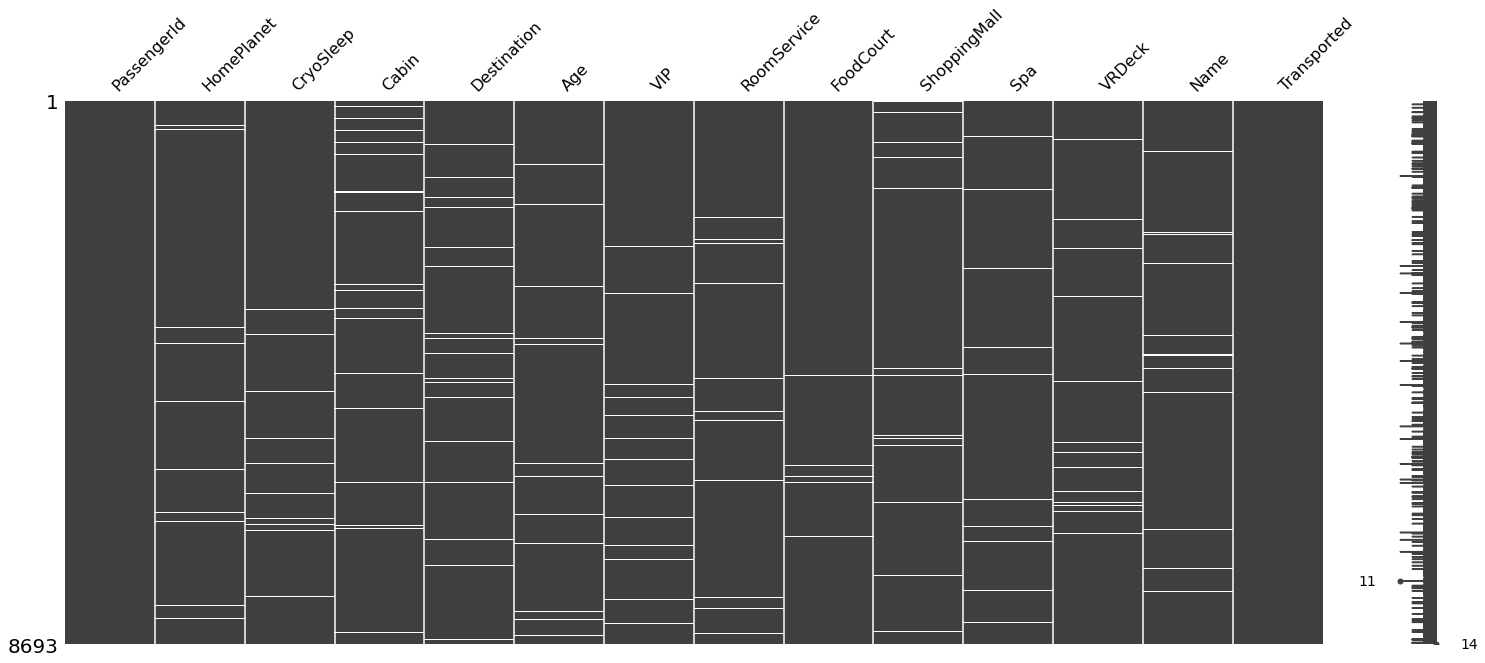

In [ ]:
# Vamos a ver el comportamiento de los valores nulos: Entrenamiento
msno.matrix(train)
plt.show()

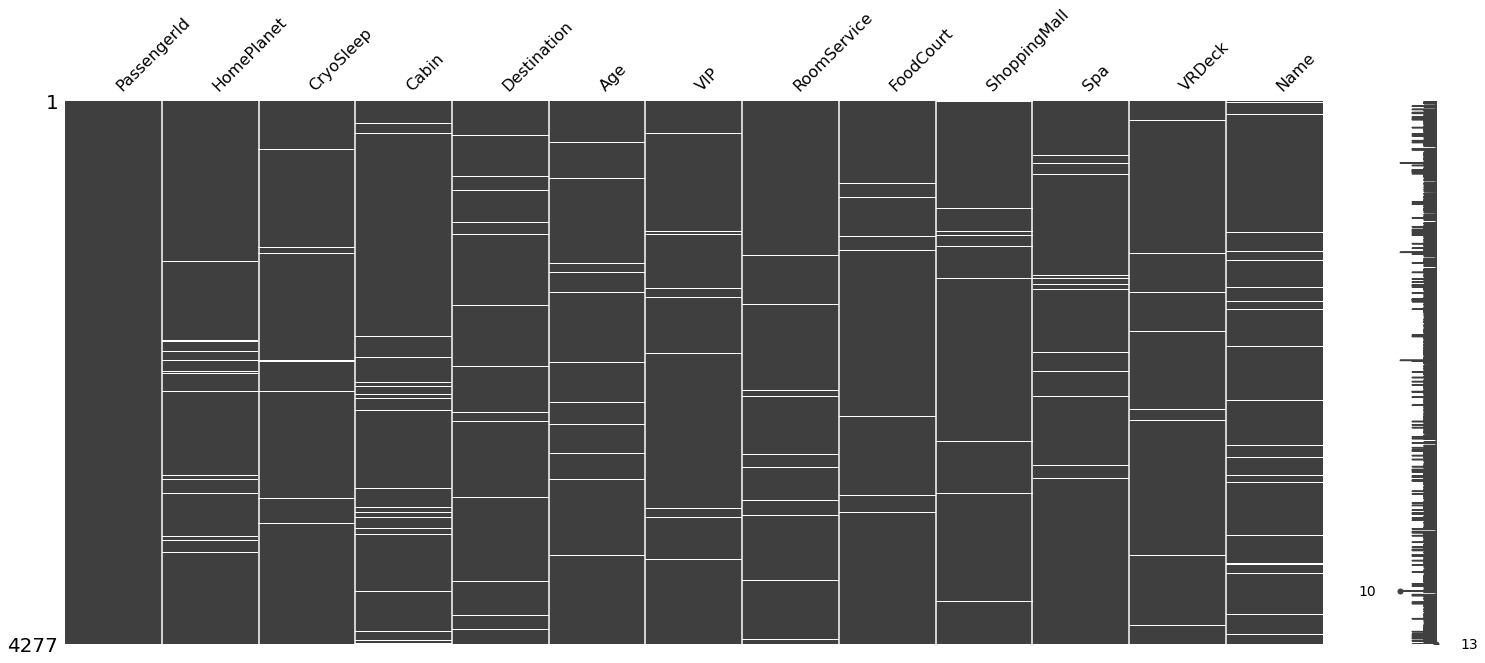

In [ ]:
# Vamos a ver el comportamiento de los valores nulos: Prueba
msno.matrix(test)
plt.show()

In [ ]:
# Revisamos el balance de los objetivos
print(train[target].value_counts())
print('True',  train[target].value_counts()[1]/len(train[target]))
print('False', train[target].value_counts()[0]/len(train[target]))

True     4378
False    4315
Name: Transported, dtype: int64
True 0.5036236051995858
False 0.4963763948004141


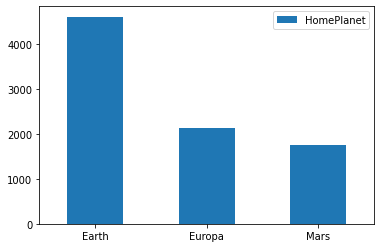

In [ ]:
# La distribución del origen de los viajeros
train['HomePlanet'].value_counts().plot.bar()
plt.xticks(rotation=0)
plt.legend()
plt.show()

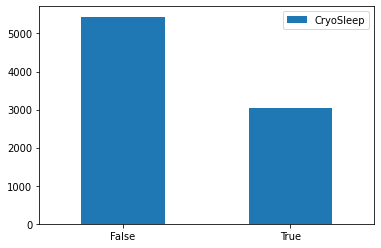

In [ ]:
# La distribución de los pasajeros con animación suspendida
train['CryoSleep'].value_counts().plot.bar()
plt.xticks(rotation=0)
plt.legend()
plt.show()

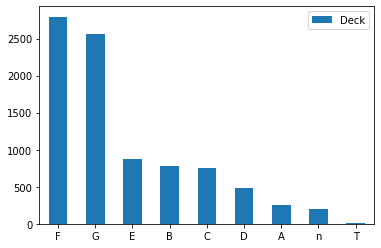

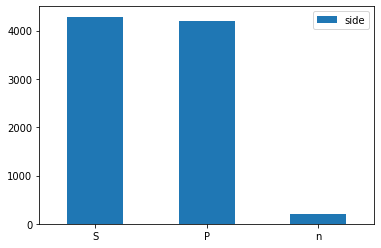

In [ ]:
# Separamos las cabinas por lados (babor o estribor) y por cubiertas.
train['Deck'] = train.Cabin.apply(lambda x:str(x)[0])
train['side'] = train.Cabin.apply(lambda x:str(x)[-1])
train['num'] =  train['Cabin'].str.extract("(\d+)")

test['Deck'] = test.Cabin.apply(lambda x:str(x)[0])
test['side'] = test.Cabin.apply(lambda x:str(x)[-1])
test['num'] =  test['Cabin'].str.extract("(\d+)")

# Imprimimos la destribución de cabinas por las cubiertas
train['Deck'].value_counts().plot.bar()
plt.xticks(rotation=0)
plt.legend()
plt.show()

# Imprimimos la destribución de cabinas por lados
train['side'].value_counts().plot.bar()
plt.xticks(rotation=0)
plt.legend()
plt.show()

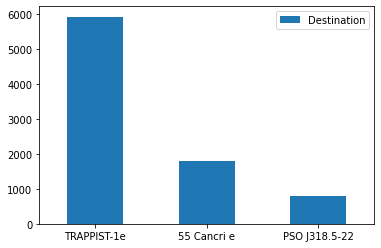

In [ ]:
# El planeta al que desembarcará el pasajero.
train['Destination'].value_counts().plot.bar()
plt.xticks(rotation=0)
plt.legend()
plt.show()

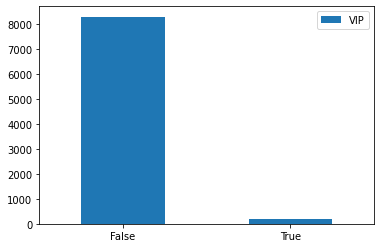

In [ ]:
# El estatus del pasajero
train['VIP'].value_counts().plot.bar()
plt.xticks(rotation=0)
plt.legend()
plt.show()

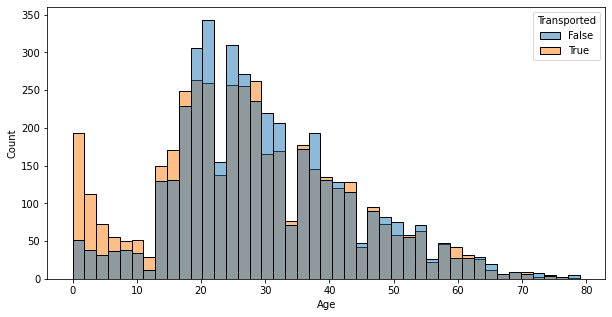

In [ ]:
# La edad de los pasajeros
plt.figure(figsize=(10,5))
sns.histplot(data=train, x='Age', hue=target)
plt.xticks(rotation=0)
plt.show()

In [ ]:
# Generamos una variable de gastos totales
# Conjunto de entrenamiento
train['Total expenses'] = train[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].sum(axis=1)
# Conjunto de pruebas
test['Total expenses'] = test[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].sum(axis=1)

In [ ]:
# Las personas que no gastan nada, es posible que esten en animación suspendida
# Si no han gastado en el resto de variables, podemos rrellenar con 0

cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

for col in cols:
  # Conjunto de entrenamiento
  mask = (train['Total expenses'] == 0)&(train[col].isnull() == True)
  train.loc[mask, col].fillna(0, inplace = True)
  # Conjunto de pruebas
  mask = (test['Total expenses'] == 0)&(test[id].isnull() == True)
  test.loc[mask, col].fillna(0, inplace = True)

# Rellenamos el estado de las personas
mask = (train['Total expenses'] == 0)&(train['CryoSleep'].isnull()==True)
train.loc[mask, 'CryoSleep'].fillna(True, inplace = True)

mask = (test['Total expenses'] == 0)&(test['CryoSleep'].isnull()==True)
test.loc[mask, 'CryoSleep'].fillna(True, inplace = True)

# Tambien se rrellenan las cabinas sin número
train['num'].fillna(0, inplace = True)
test['num'].fillna(0, inplace = True)

In [ ]:
# Para el resto de casos, vamos a rellenar con los valores medios
# Se rellenan los valores nulos de las columnas numericas
imp = SimpleImputer(missing_values=np.nan, strategy='mean')

# Conjunto de entrenamiento 
train[num_cols] = imp.fit_transform(train[num_cols])

# Conjunto de pruebas
test[num_cols] = imp.transform(test[num_cols])

In [ ]:
# Valores nulos
print('='*65)
print('='*15 +' Valores nulos de entrenamiento '+'='*15)
print('='*65)
print(train.isnull().sum())
print('='*65)
print('='*15 +' Valores nulos de prueba '+'='*15)
print('='*65)
print(test.isnull().sum())

=============== Valores nulos de entrenamiento ===============
PassengerId         0
HomePlanet        201
CryoSleep         217
Cabin             199
Destination       182
Age                 0
VIP               203
RoomService         0
FoodCourt           0
ShoppingMall        0
Spa                 0
VRDeck              0
Name              200
Transported         0
Deck                0
side                0
num                 0
Total expenses      0
dtype: int64
=============== Valores nulos de prueba ===============
PassengerId         0
HomePlanet         87
CryoSleep          93
Cabin             100
Destination        92
Age                 0
VIP                93
RoomService         0
FoodCourt           0
ShoppingMall        0
Spa                 0
VRDeck              0
Name               94
Deck                0
side                0
num                 0
Total expenses      0
dtype: int64


In [ ]:
# Llenamos el resto de variables con su valor mas frecuente
imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

# Conjunto de entrenamiento 
train[cat_cols] = imp.fit_transform(train[cat_cols])

# Conjunto de pruebas
test[cat_cols] = imp.transform(test[cat_cols])

# Revisamos los valores nulos
print('='*65)
print('='*15 +' Valores nulos de entrenamiento '+'='*15)
print('='*65)
print(train.isnull().sum())
print('='*65)
print('='*15 +' Valores nulos de prueba '+'='*15)
print('='*65)
print(test.isnull().sum())

=============== Valores nulos de entrenamiento ===============
PassengerId       0
HomePlanet        0
CryoSleep         0
Cabin             0
Destination       0
Age               0
VIP               0
RoomService       0
FoodCourt         0
ShoppingMall      0
Spa               0
VRDeck            0
Name              0
Transported       0
Deck              0
side              0
num               0
Total expenses    0
dtype: int64
=============== Valores nulos de prueba ===============
PassengerId       0
HomePlanet        0
CryoSleep         0
Cabin             0
Destination       0
Age               0
VIP               0
RoomService       0
FoodCourt         0
ShoppingMall      0
Spa               0
VRDeck            0
Name              0
Deck              0
side              0
num               0
Total expenses    0
dtype: int64


In [ ]:
# Extraemos el grupo al que pertenece el pasajero.
train['group'] =  train[id].str.extract("(\d+)")
test['group'] =  test[id].str.extract("(\d+)")

# Verificamos si el pasajero es mayor de 18 años.
train['Adult'] = train['Age']>=18
test['Adult'] = test['Age']>=18

# Generamos una variable del tamaño del grupo.
g_temp = pd.DataFrame({'size_group':train['group'].value_counts()})
g_temp = g_temp.rename_axis('group').reset_index()
train = train.merge(g_temp, on='group')

g_temp = pd.DataFrame({'size_group':test['group'].value_counts()})
g_temp = g_temp.rename_axis('group').reset_index()
test = test.merge(g_temp, on='group')

In [ ]:
# Vamos a encodear o codificar las variables categoricas.
cat_cols = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Deck', 'side', 'Adult']
num_cols = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Total expenses']

for i in cat_cols:
    le=LabelEncoder()
    arr=np.concatenate((train[i], test[i])).astype(str)
    le.fit(arr)
    train[i]=le.transform(train[i].astype(str))
    test[i]=le.transform(test[i].astype(str))

# Tambien el objetivo
le = LabelEncoder()
train[target] = le.fit_transform(train[target])

In [ ]:
# Vamos a separar los datos de los objetivos
X = train.copy()
X.drop([id, 'Cabin', 'Name', target, 'group', 'num'], axis = 1, inplace = True)
y = train.pop(target)

X_test = test.copy()
X_test.drop([id, 'Cabin', 'Name', 'group', 'num'], axis = 1, inplace = True)

In [ ]:
# Vamos a procesar los datos numericos
sc = StandardScaler()
X[num_cols] = X[num_cols].astype(float)
X_test[num_cols] = X_test[num_cols].astype(float)

X[num_cols] = sc.fit_transform(X[num_cols])
X_test[num_cols] = sc.transform(X_test[num_cols])

In [ ]:
# Vamos a encontrar cual es la principal diferencia entre los sets
X['set'] = 0
X_test['set'] = 1
sets = pd.concat([X, X_test], axis=0)
X_sets = sets.copy()
X_sets.drop('set', axis=1, inplace=True)
y_sets = sets.pop('set')

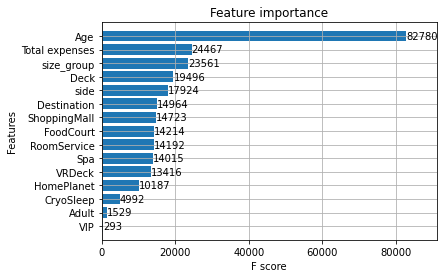

In [ ]:
# Definimos y entrenamos el modelo
clf = XGBClassifier(max_depth=100, n_estimators=500, 
                    random_state=0, 
                    colsample_bytree=0.8)

# Graficamos las variables por orden de importancia
clf.fit(X_sets, y_sets)
plot_importance(clf, height=0.8)
plt.show()

In [ ]:
# La edad es la principal variable que diferencia los sets
y_hat_sets = clf.predict(X_sets)
accuracy_score(y_sets, y_hat_sets)

0.9447185813415574

In [ ]:
# Eliminamos la variable de edad
X.drop('Age', axis=1, inplace=True)
X_test.drop('Age', axis=1, inplace=True)

# Vamos a separar los conjuntos de entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X, y, 
                                                  test_size=0.3,
                                                  random_state = 0,
                                                  shuffle = True)

# Observamos las dimensiones de entrada
X_train.shape

(6085, 15)

In [ ]:
# Construimos el modelo

# Capa de entrada
inputs = keras.Input(shape=(X_train.shape[1]))

# Capas ocultas
layer_1 = layers.Dense(512, activation = 'relu')(inputs)
layer_2 = layers.Dropout(0.5)(layer_1)
layer_3 = layers.Dense(256, activation = 'relu')(layer_2)
layer_4 = layers.Dropout(0.5)(layer_3)
layer_5 = layers.Dense(64, activation = 'relu')(layer_4)
layer_6 = layers.Dense(64, activation = 'relu')(layer_5)

# Capa de salida
outputs = layers.Dense(1, activation='sigmoid')(layer_6)

# Construcción del modelo
model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
# Compilacion del modelo
model.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = ['binary_accuracy'],
)

# Parada de sobreajuste
early_stopping = keras.callbacks.EarlyStopping(
    patience = 15,
    min_delta = 0.001,
    restore_best_weights = True,
    monitor="val_loss",
    mode = 'auto'
)

# Entrenamiento del modelo
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=1,
    epochs=200,
    callbacks=[early_stopping],
)

Epoch 1/200
6085/6085 [==============================] - 21s 3ms/step - loss: 0.5144 - binary_accuracy: 0.7504 - val_loss: 0.4623 - val_binary_accuracy: 0.7788
Epoch 2/200
6085/6085 [==============================] - 19s 3ms/step - loss: 0.4782 - binary_accuracy: 0.7762 - val_loss: 0.4665 - val_binary_accuracy: 0.7845
Epoch 3/200
6085/6085 [==============================] - 21s 3ms/step - loss: 0.4727 - binary_accuracy: 0.7847 - val_loss: 0.4528 - val_binary_accuracy: 0.7857
Epoch 4/200
6085/6085 [==============================] - 27s 4ms/step - loss: 0.4662 - binary_accuracy: 0.7896 - val_loss: 0.4647 - val_binary_accuracy: 0.7887
Epoch 5/200
6085/6085 [==============================] - 21s 3ms/step - loss: 0.4686 - binary_accuracy: 0.7888 - val_loss: 0.4528 - val_binary_accuracy: 0.7814
Epoch 6/200
6085/6085 [==============================] - 18s 3ms/step - loss: 0.4590 - binary_accuracy: 0.7915 - val_loss: 0.4702 - val_binary_accuracy: 0.7791
Epoch 7/200
6085/6085 [=================

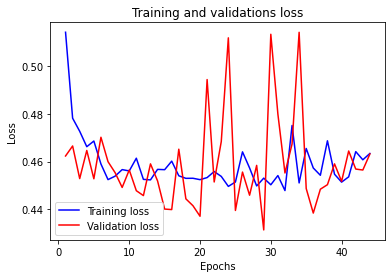

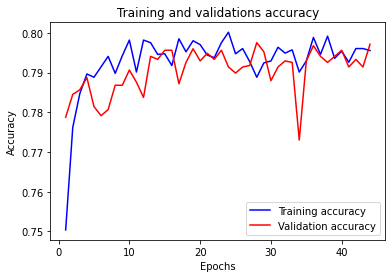

In [ ]:
# Ploteamos las perdidas del modelo
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values)+1)
plt.plot(epochs, loss_values, 'b', label = 'Training loss')
plt.plot(epochs, val_loss_values, 'r', label = 'Validation loss')
plt.title('Training and validations loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Ploteamos la validación del modelo
history_dict = history.history
acc_values = history_dict['binary_accuracy']
val_acc_values = history_dict['val_binary_accuracy']
epochs = range(1, len(acc_values)+1)
plt.plot(epochs, acc_values, 'b', label = 'Training accuracy')
plt.plot(epochs, val_acc_values, 'r', label = 'Validation accuracy')
plt.title('Training and validations accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

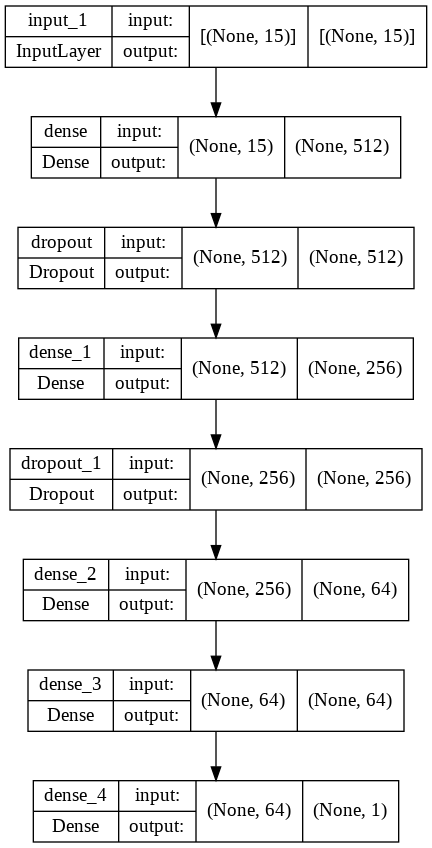

In [ ]:
# Graficamos el esquema de la red neuronal
plot_model(model, show_shapes=True)

In [ ]:
# Construimos el segundo modelo
model_2 = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=600, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

# Entrenamos el modelo
model_2.fit(X_train, y_train,
            early_stopping_rounds = 100, 
            eval_set=[(X_val, y_val)], 
            eval_metric=['error','logloss','auc'],
            verbose=0)


XGBClassifier(n_estimators=600)

In [ ]:
# Definimos una función que genera un set de datos de predicciones 
def predict_fin(df):
  y_hat_1 = model.predict(df).reshape(len(df),)

  y_hat_2 = model_2.predict_proba(df)
  y_hat_2 = y_hat_2[:,1].reshape(y_hat_2.shape[0],)

  X_2 = pd.DataFrame({'m1':y_hat_1, 'm2':y_hat_2,})
  return X_2

In [ ]:
# Generamos el set de predicciones
X_2 = predict_fin(X_train)

# Dividimos el set para el entrenamiento del modelo ensamblado
X_train_2, X_val_2, y_train_2, y_val_2 = train_test_split(X_2, y_train, 
                                                  test_size=0.3,
                                                  random_state = 0,
                                                  shuffle = True)

In [ ]:
# Construimos el modelo ensamblado
model_3 = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=600, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

# Entrenamos el modelo
model_3.fit(X_train_2, y_train_2,
            early_stopping_rounds = 100, 
            eval_set=[(X_val_2, y_val_2)], 
            eval_metric=['error','logloss','auc'],
            verbose=0)


XGBClassifier(n_estimators=600)

In [ ]:
# Generamos las predicciones
X_test = predict_fin(X_test)
y_hat = model_3.predict(X_test)

In [ ]:
# Generamos el archivo respuesta
y_hat = np.where(y_hat >= 0.50, True, False)
sub['Transported'] = y_hat
sub.to_csv('submission.csv', index=False)

In [ ]:
# Evaluamos el modelo
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from sklearn.metrics import precision_score

X_train = predict_fin(X_train)
y_hat = model_3.predict(X_train)

jaccard = jaccard_score(y_train, y_hat)
f1 = f1_score(y_train, y_hat)
logloss = log_loss(y_train, y_hat)
precision = precision_score(y_train, y_hat)

print('Jaccard score: %.2f' % jaccard)
print('F1 score: %.2f' % f1)
print('Log loss score: %.2f' % logloss)
print('Precision score: %.2f' % precision)

Jaccard score: 0.73
F1 score: 0.84
Log loss score: 5.49
Precision score: 0.84
